# W207- Applied Machine Learning - Section 1

## Title: Random Acts of Pizza

## Team 2: Sartaj Singh Baveja, Tim Spittle, Jay Venkata & Angela Wu

According to Alex, for the baseline submission

1. ~~Who are the members of the group?~~

2. ~~What’s the title of your project?~~

3. ~~Description of your project in just 2-3 paragraphs~~

4. ~~What features are available to work with in your data?~~

5. What type of feature engineering you can see fit in your model (top view)? This can improve later when you start working and change features to improve performance (Ex: add features that are combinations of other features, etc.)

6. ~~What is the expected outcome of your project?~~

7. ~~Run preliminary likelihoods for data already present to include prior scores~~

8. What classification algorithms would you use and why?

9. ~~Try using a baseline approach first and base your improvement on it (look into ZeroR rule)~~

10. ~~How many observations do you have and what do they look like (describe it)?~~

11. What hyper parameters would you consider changing and what you achieve with each?

12. Would you consider using dimension reduction and if so, why? What kind?

13. Prepare 6-8 min presentation for each group

14. Anything else that you think is important to put in writing and discuss

## Overview

This competition contains a dataset with textual requests for pizza from the Reddit community - Random Acts of Pizza (https://www.reddit.com/r/Random_Acts_Of_Pizza/) together with their outcome (successful/unsuccessful) and meta-data. 

The dataset includes 5671 requests collected from the Reddit community between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.  

Outcome of Project: By getting a sense of the dynamics and factors of a request that most likely would influence its success, the team hopes to build a model capable of predicting which requests will garner a cheesy (but sincere!) act of kindness and will result in a pizza purchase.

## Data Preparation

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
from pprint import pprint
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# SK Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Each entry in pizza_request_dataset.json corresponds to one request (the first and only request by the requester).

### Fields in each request

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| in_test_set | Boolean indicating whether this request was part of our test set. |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

### Initial Loading

In [4]:
## Load the training data in JSON
with open(os.path.join(os.getcwd(), 'train.json')) as org_train_data_file:    
    org_train_data = json.load(org_train_data_file)

## Load the test data in JSON
with open(os.path.join(os.getcwd(), 'test.json')) as org_test_data_file:    
    org_test_data = json.load(org_test_data_file)

In [5]:
# Convert the training data in JSON to pandas dataframe
org_train_df_raw = pd.io.json.json_normalize(org_train_data)
org_train_df = pd.DataFrame.from_records(org_train_data)
org_train_df.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


We will split 60% of our data into training and the rest will be our dev dataset

In [6]:
## Split the original training data into training and development
np.random.seed(0)
train_df, dev_df = train_test_split(org_train_df, test_size = 0.4, stratify=org_train_df['requester_received_pizza'])

## Verify the stratefication works
print(train_df["requester_received_pizza"].mean())
print(dev_df["requester_received_pizza"].mean())

0.24587458745874588
0.24628712871287128


In [7]:
# Convert the test data in JSON to pandas dataframe
test_df = pd.DataFrame.from_records(org_test_data)
test_df.head()

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,t3_i8iy4,Hey all! It's about 95 degrees here and our ki...,[request] pregger gf 95 degree house and no fo...,42.083866,0.0,57,0,10,0,16,"[AskReddit, COents, Denver, DenverBroncos, Lib...",364,840,j_like,1.308963e+09,1.308960e+09
1,N/A,t3_1mfqi0,I didn't know a place like this exists! \n\nI ...,"[Request] Lost my job day after labour day, st...",223.784537,0.0,145,0,36,0,29,"[Android, AskReddit, GrandTheftAutoV, IAmA, Mi...",516,1448,0110110101101100,1.379264e+09,1.379260e+09
2,N/A,t3_lclka,Hi Reddit. Im a single dad having a really rou...,(Request) pizza for my kids please?,0.000000,0.0,0,0,0,0,0,[],0,0,singledad22601,1.318636e+09,1.318633e+09
3,N/A,t3_1jdgdj,Hi I just moved to Waltham MA from my home sta...,[Request] Just moved to a new state(Waltham MA...,481.311273,0.0,277,0,17,0,30,"[AdviceAnimals, Art, AskReddit, GetMotivated, ...",1058,2062,Neuronut,1.375220e+09,1.375217e+09
4,N/A,t3_t2qt4,We're just sitting here near indianapolis on o...,"[Request] Two girls in between paychecks, we'v...",0.000000,0.0,0,0,0,0,0,[],0,0,so_damn_hungry,1.335934e+09,1.335931e+09


In [8]:
train_columns = set(train_df.columns.values)
test_columns = set(test_df.columns.values)

# Columns that are ONLY in the train dataset
train_only_columns = train_columns - test_columns
print("Columns in Train but not Test:")
print("\n".join(sorted(train_only_columns)))

# Columns that are ONLY in the test dataset
test_only_columns = test_columns - train_columns
print("\nColumns in Test but not Train:")
print("\n".join(sorted(test_only_columns)))

# Common columns
common_columns = train_columns - train_only_columns
print("\nColumns common to Test and Train:")
print("\n".join(sorted(common_columns)))

Columns in Train but not Test:
number_of_downvotes_of_request_at_retrieval
number_of_upvotes_of_request_at_retrieval
post_was_edited
request_number_of_comments_at_retrieval
request_text
requester_account_age_in_days_at_retrieval
requester_days_since_first_post_on_raop_at_retrieval
requester_number_of_comments_at_retrieval
requester_number_of_comments_in_raop_at_retrieval
requester_number_of_posts_at_retrieval
requester_number_of_posts_on_raop_at_retrieval
requester_received_pizza
requester_upvotes_minus_downvotes_at_retrieval
requester_upvotes_plus_downvotes_at_retrieval
requester_user_flair

Columns in Test but not Train:


Columns common to Test and Train:
giver_username_if_known
request_id
request_text_edit_aware
request_title
requester_account_age_in_days_at_request
requester_days_since_first_post_on_raop_at_request
requester_number_of_comments_at_request
requester_number_of_comments_in_raop_at_request
requester_number_of_posts_at_request
requester_number_of_posts_on_raop_at_reques

In [9]:
train_df.describe()

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,...,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2.424000e+03,2.424000e+03
mean,2.490924,6.243399,2.852310,257.076562,761.135408,15.854911,519.375076,117.129538,289.739274,0.609323,...,40.856848,0.060231,1.224422,18.267739,1134.673267,2684.942244,3534.171617,7481.891089,1.342733e+09,1.342729e+09
std,3.159131,10.324260,4.519556,308.291897,334.844271,68.349921,266.825980,197.255766,359.259651,3.373627,...,81.979290,0.328333,0.576724,22.037967,2870.852260,5265.463552,18798.464623,25363.399331,2.323524e+07,2.323456e+07
min,0.000000,0.000000,0.000000,0.000000,45.291562,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-173.000000,-173.000000,0.000000,0.000000,1.297723e+09,1.297723e+09
25%,1.000000,2.000000,0.000000,2.893015,524.856794,0.000000,280.503828,0.000000,7.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,3.000000,22.000000,8.000000,50.000000,1.320282e+09,1.320279e+09
50%,2.000000,4.000000,1.000000,158.299797,754.348223,0.000000,522.899485,24.000000,112.500000,0.000000,...,13.000000,0.000000,1.000000,11.000000,174.500000,699.000000,361.000000,1269.500000,1.342686e+09,1.342682e+09
75%,3.000000,7.000000,4.000000,388.884178,902.263547,0.000000,776.226670,142.000000,475.000000,0.000000,...,46.000000,0.000000,1.000000,27.000000,1167.000000,3305.250000,2307.750000,6921.750000,1.364291e+09,1.364288e+09
max,47.000000,276.000000,61.000000,2809.750787,2879.276319,739.771007,1025.407593,994.000000,1000.000000,88.000000,...,999.000000,5.000000,6.000000,162.000000,87911.000000,108977.000000,789287.000000,883299.000000,1.381373e+09,1.381345e+09


In [10]:
dev_df.describe()

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,...,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1.616000e+03,1.616000e+03,1.616000e+03,1.616000e+03
mean,2.324876,6.086015,2.899134,250.851605,752.528689,17.260219,518.420399,112.051361,288.955446,0.698639,...,41.594059,0.068688,1.261139,17.790223,1198.189975,2773.441832,4.056832e+03,8.247335e+03,1.342974e+09,1.342971e+09
std,2.804733,11.352638,5.014811,295.647286,330.340418,73.983087,269.516709,187.277828,354.743297,3.473583,...,79.017479,0.321929,0.640143,21.279765,4712.831861,7519.415498,3.375351e+04,5.358297e+04,2.347930e+07,2.347862e+07
min,0.000000,0.000000,0.000000,0.000000,75.817535,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-39.000000,-16.000000,0.000000e+00,1.000000e+00,1.306186e+09,1.306183e+09
25%,1.000000,2.000000,0.000000,4.615590,519.981386,0.000000,276.464363,0.000000,8.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,3.000000,21.000000,9.000000e+00,5.500000e+01,1.320863e+09,1.320863e+09
50%,2.000000,4.000000,1.000000,154.850752,750.433814,0.000000,534.842367,24.000000,116.500000,0.000000,...,13.000000,0.000000,1.000000,11.000000,175.000000,714.000000,3.350000e+02,1.298000e+03,1.342154e+09,1.342151e+09
75%,3.000000,7.000000,4.000000,391.212520,896.280307,0.000000,776.019974,138.000000,483.000000,0.000000,...,46.000000,0.000000,1.000000,27.000000,1158.000000,3301.750000,2.300750e+03,6.745250e+03,1.365002e+09,1.364998e+09
max,32.000000,345.000000,61.000000,1992.518657,2733.297060,785.457685,927.447442,990.000000,1000.000000,77.000000,...,972.000000,4.000000,9.000000,186.000000,155010.000000,223708.000000,1.286864e+06,2.046482e+06,1.381552e+09,1.381523e+09


### Data Cleaning

- De-duplicate
- Consider cleaning or removing observations with missing/erroneous values

## Exploratory Data Analysis  

Success of these reddit requests depend on factors like who is asking, how they are asking, and when are they asking. This will help us understand the attributes of the best formulated requests and why certain ones are promoted higher than others.

### Features of Interest

#### Meta-Data Features

_General Note_ Many features not present in test data are not known at time of posting, therefore they will be ignored for this analysis. This includes the "at retrieval" statistics, RAOP "user flair", and raw (i.e. non-"edit aware") request text.  

**Time**  
Time is a very basic but important feature to include. Logically, there are likely times of day when more users are active on RAOP and this may have varied effects on the behaviors we observe:  
- More users requesting may make the environment more competitive (i.e. harder for a single post to stand out) 
- Conversely, more users giving may make likelihood of success higher (all things equal).  
    - _NOTE_, however, that we cannot observe the time of giving in this dataset.  

These periods of increased requests/gives may not coincide with one another and it will be important to understand the periods of high and low activity relative to UTC; there may be multiple shifts throughout a day coinciding with higher activity in different countries/time zones around the globe.  

**Requester Profile**    
In attempting to predict likelihood of fulfillment for a request on RAOP based on featues related to the profile of the requester, we believe it may be important to make a distinction between: 
- _Primary_ profile features (i.e. features which an average reader/potential giver on RAOP may see/consider)
    - Age of account - whether it appears to be a new/throwaway account or a longtime veteran  
    - Number and frequency of requests - if the requester has made requests before
- _Secondary_ features (i.e. extended detail about requester activity on Reddit that a potential giver might not see, and therefore it wouldn't have as much influence on their likelihood of fulfilling the request or not)  
    - Comments made
    - Posts
    - Sub-Reddits in which they participate
    - Upvotes/Downvotes

**Community Effects (Secondary)**  
The training data constains featues related to the reactions to a request on RAOP (upvotes/downvotes/comments) which, while not available in the test data and not appropriate for success classifcation algorithm (given that we don't know this info at time of the request nor do we know if this activity happened before/after the request was fulfilled), positive or contentious reactions to posts may be correlated with success/fulfillment. Therefore, it may be worhtwhile to explore these relationships and, if useful, a sensitivity analysis that predicts these metrics to provide additional insight into predictive features.  

C:\Users\manat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


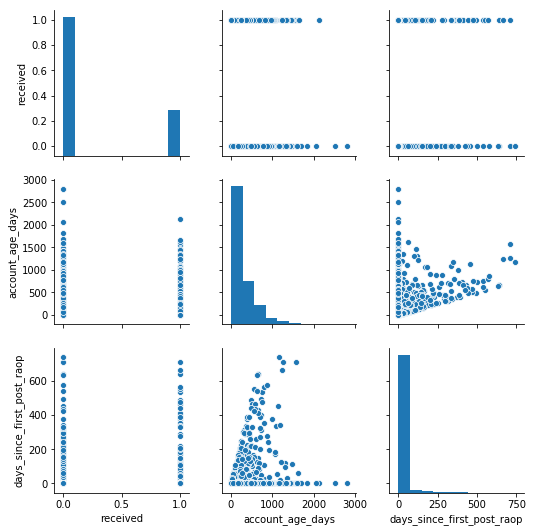

In [11]:
train_df['received'] = train_df.loc[:,'requester_received_pizza'].astype(np.int_)
train_df_lim = train_df.loc[:,('received', \
                               'requester_account_age_in_days_at_request', \
                               'requester_days_since_first_post_on_raop_at_request')]
train_df_lim = train_df_lim.rename(index = str, columns={'requester_account_age_in_days_at_request': 'account_age_days', \
                                                         'requester_days_since_first_post_on_raop_at_request': 'days_since_first_post_raop'})
sns.pairplot(train_df_lim);

### EDA:  
1. Request timing- Day of the week and time of the day
2. Text Field length
3. Upvotes vs Downvotes  
4. Requester account vs activity - evaluate the various requester feature differences between those whose requests were fulfilled, and those whose requests were not
5. Perform Topic Modeling using LDA or NMF to identify most common topics and then, we'll be able to group them into categories (https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730) 
6. Word clouds around successful/unsuccessful words  

### To Do:
- **Read Stanford paper**

#### Time Variables (JV)

In [12]:
# Time Variables Code

#### Requester Profile Variables (TS)

In [13]:
# Requester Profile Variables Code
train_df_profile = train_df.loc[:,('received',
                                   'requester_account_age_in_days_at_request', 
                                   'requester_days_since_first_post_on_raop_at_request',
                                   'requester_number_of_comments_at_request', 'requester_number_of_comments_in_raop_at_request',
                                   'requester_number_of_posts_at_request', 'requester_number_of_posts_on_raop_at_request',
                                   'requester_number_of_subreddits_at_request', 'requester_subreddits_at_request',
                                   'requester_upvotes_minus_downvotes_at_request', 'requester_upvotes_plus_downvotes_at_request')]
# Rename for simplicity
train_df_profile = train_df_profile.rename(index = str, 
                                           columns={'requester_account_age_in_days_at_request': 'account_age_days',
                                                    'requester_days_since_first_post_on_raop_at_request': 'days_since_first_post_raop',
                                                    'requester_number_of_comments_in_raop_at_request': 'number_comments_raop',
                                                    'requester_number_of_posts_on_raop_at_request': 'number_posts_raop',
                                                    'requester_number_of_comments_at_request': 'number_comments',
                                                    'requester_number_of_posts_at_request': 'number_posts',
                                                    'requester_number_of_subreddits_at_request': 'number_subreddits',
                                                    'requester_subreddits_at_request': 'subreddits_list',
                                                    'requester_upvotes_minus_downvotes_at_request': 'up_minus_down',
                                                    'requester_upvotes_plus_downvotes_at_request': 'up_plus_down'})
# Renamed to:
# 'received',
# 'account_age_days',  'days_since_first_post_raop',
# 'number_comments',   'number_comments_raop',
# 'number_posts',      'number_posts_raop',
# 'number_subreddits', 'subreddits_list',
# 'up_minus_down',     'up_plus_down'

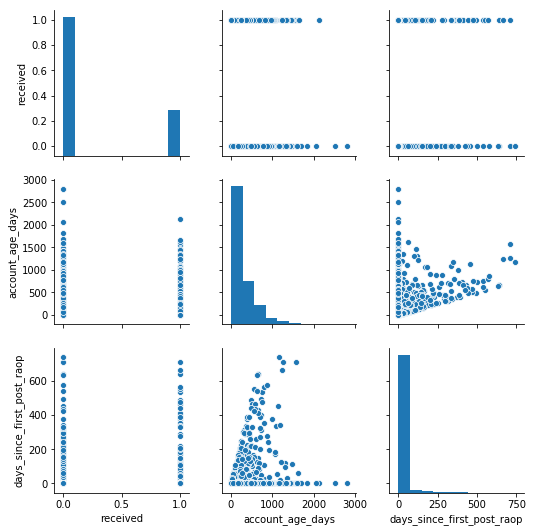

In [14]:
# Just age and RAOP participation
sns.pairplot(train_df_profile.loc[:,['received', 'account_age_days', 'days_since_first_post_raop']]);

NOTES:
- Interesting that many 0-day accounts and first time posters
    - For account age we might want to isolate 0 and then stratify by a few key buckets (max of 8 years is a long time)
    - For days_since_post defintely create first time vs repeat
        - Also take a look at long right tail (500 seems ridiculous)
- floor on mid-right plot shows that some people post to raop on first day of account then continue on until posting again

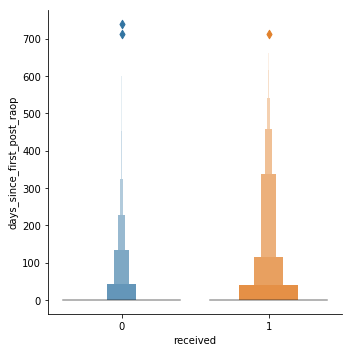

In [15]:
# Alternative plot format to better show comparative distribution of received vs. not
    # Hee showing that multiple posters actually have a more favorable distribution (though likely from smaller sample)
sns.catplot(x = "received", y = "days_since_first_post_raop", kind = "boxen",
            data = train_df_profile.sort_values("received"));

NOTES:
- Big Up/Down vote outlier - going to remove, doesn't seem reasonable (even if there is an explanation for who that person is and why they have so much voting)

C:\Users\manat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


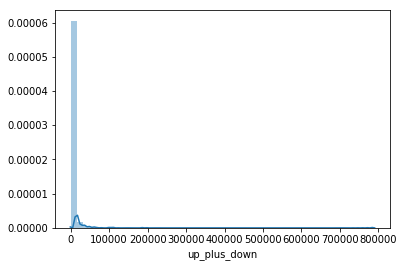

In [16]:
sns.distplot(train_df_profile.loc[:,'up_plus_down']);

In [17]:
# Remove outlier up_plus_down
train_df_profile.nlargest(3, 'up_plus_down')

,received,account_age_days,days_since_first_post_raop,number_comments,number_comments_raop,number_posts,number_posts_raop,number_subreddits,subreddits_list,up_minus_down,up_plus_down
325,0,276.103021,0.000000,423,0,809,0,71,"[AdviceAnimals, AskReddit, AskScienceFiction, ...",87911,789287
4013,0,473.575671,1.046516,736,1,187,0,67,"[4chan, AdviceAnimals, Art, AskReddit, DIY, Fe...",23593,194891
1950,1,444.186377,50.167373,306,43,66,3,27,"[AskReddit, CheapShark, Fixxit, IAmA, Random_A...",23293,184831


NOTES:
- Such a long right tail and the person with the most up_plus_down is not even the most frequent poster or oldest account, just a troll. Remove

In [18]:
print(train_df_profile.shape)
train_df_profile_clean = train_df_profile[train_df_profile.up_plus_down != 789287]
print(train_df_profile_clean.shape)

(2424, 11)
(2423, 11)


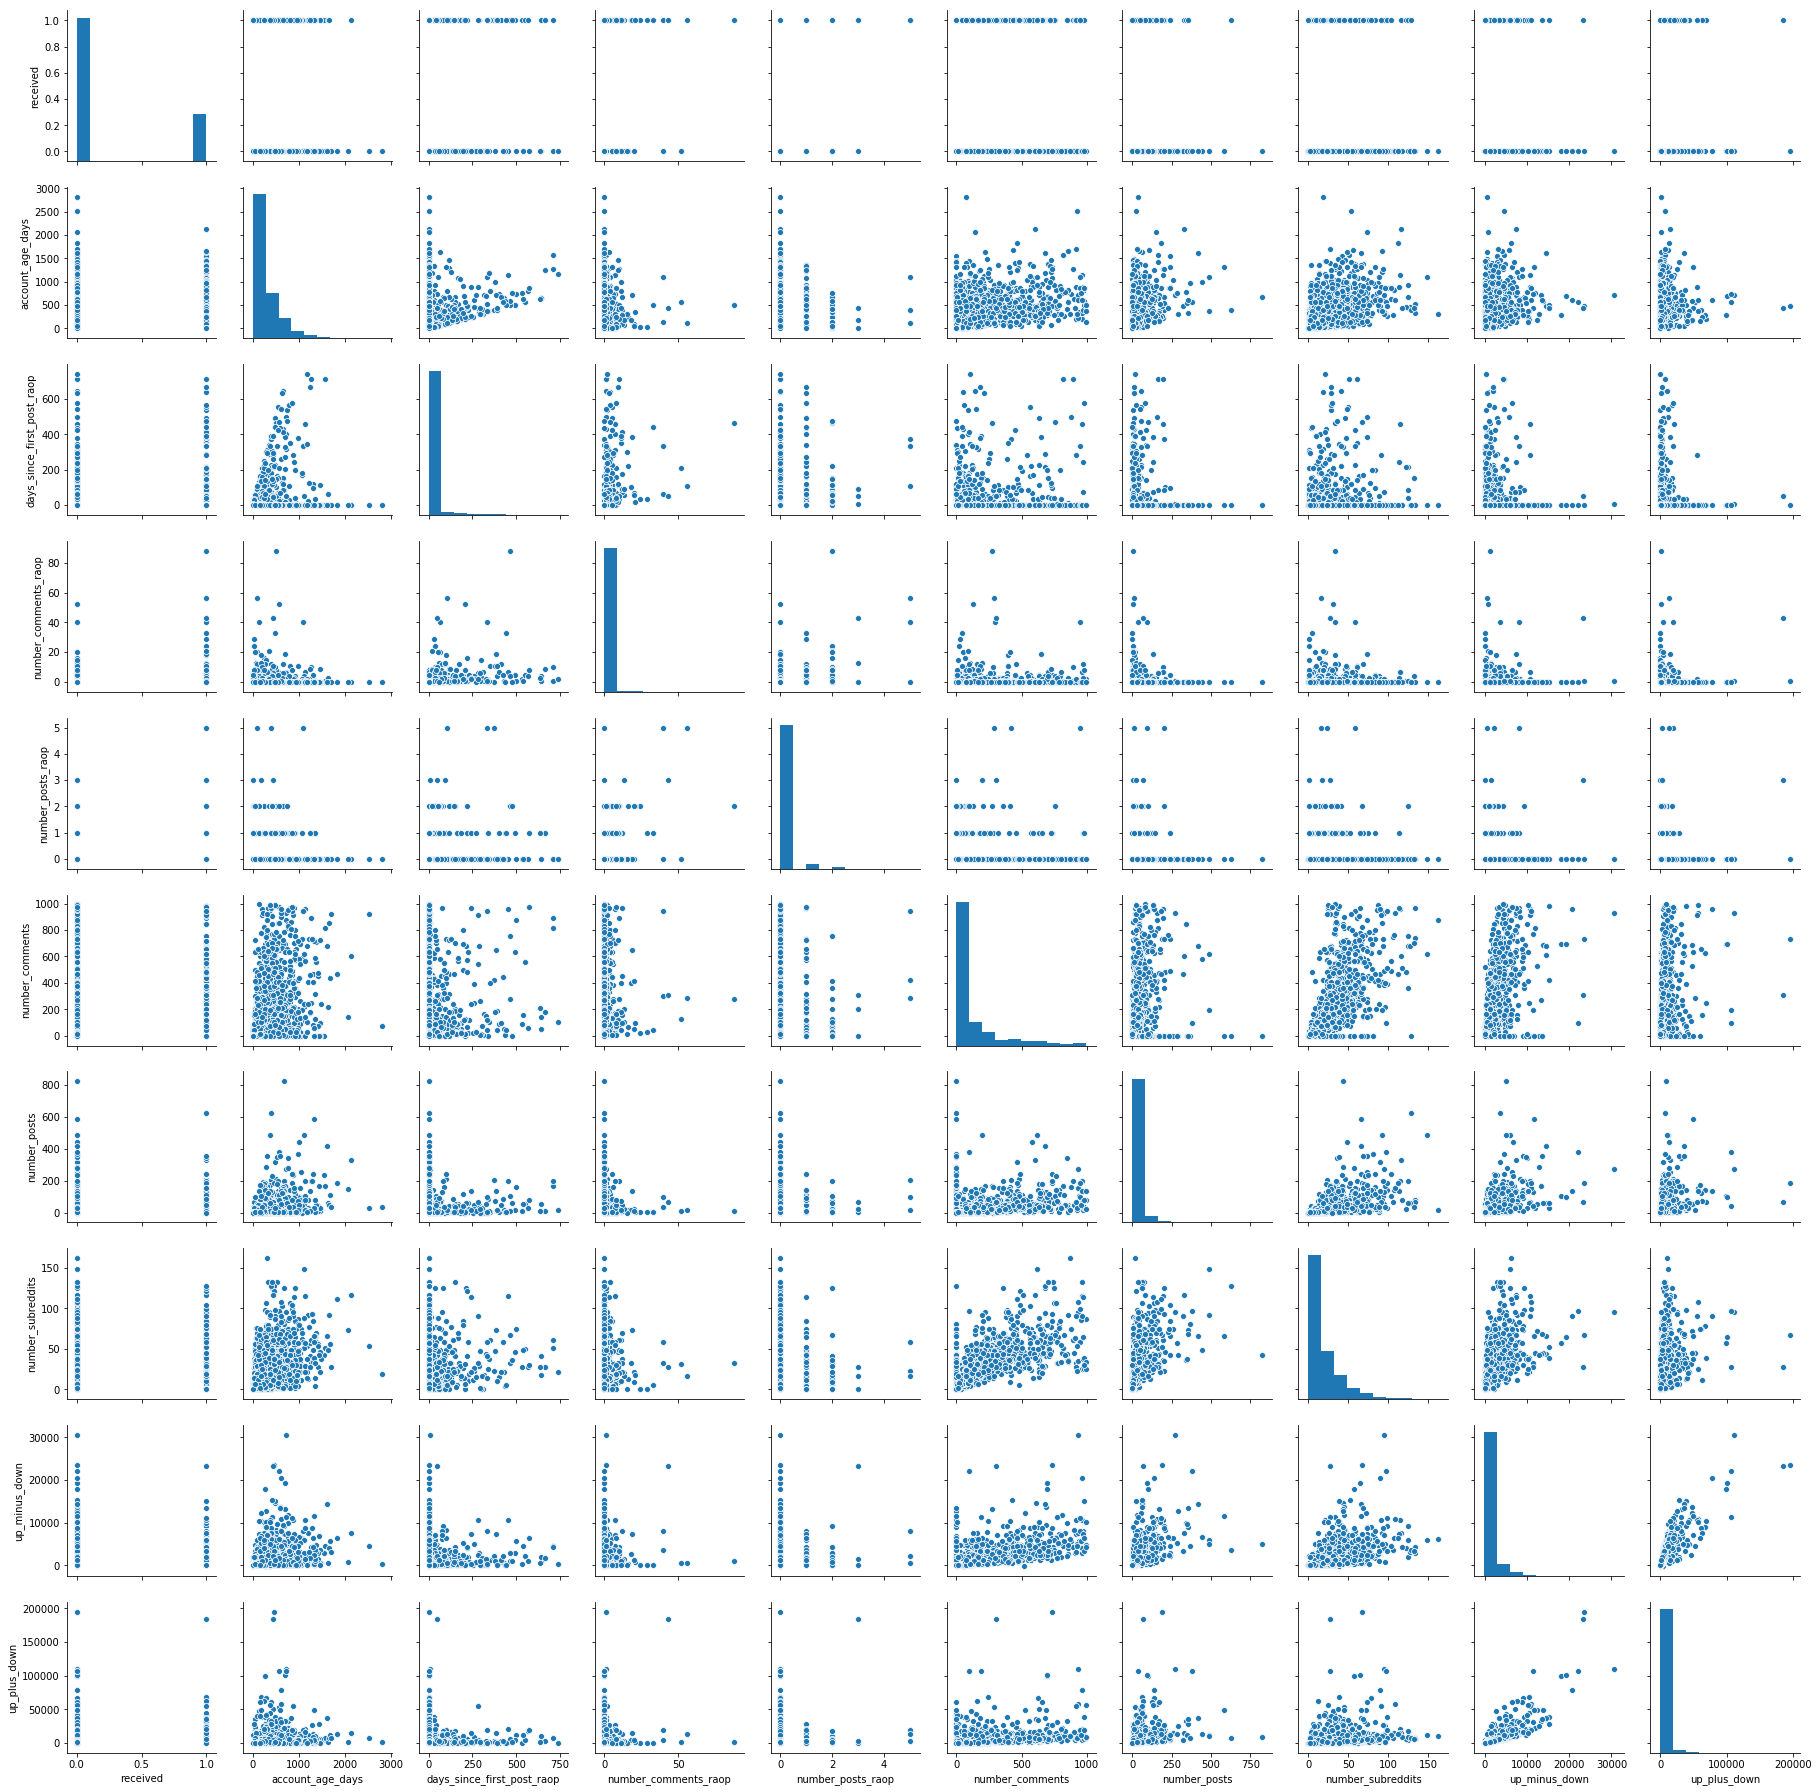

In [19]:
# Try pairplot again now that outlier is removed
sns.pairplot(train_df_profile_clean.loc[:,['received', 'account_age_days', 'days_since_first_post_raop', 
                                           'number_comments_raop', 'number_posts_raop', 
                                           'number_comments', 'number_posts', 'number_subreddits',
                                           'up_minus_down', 'up_plus_down']]);

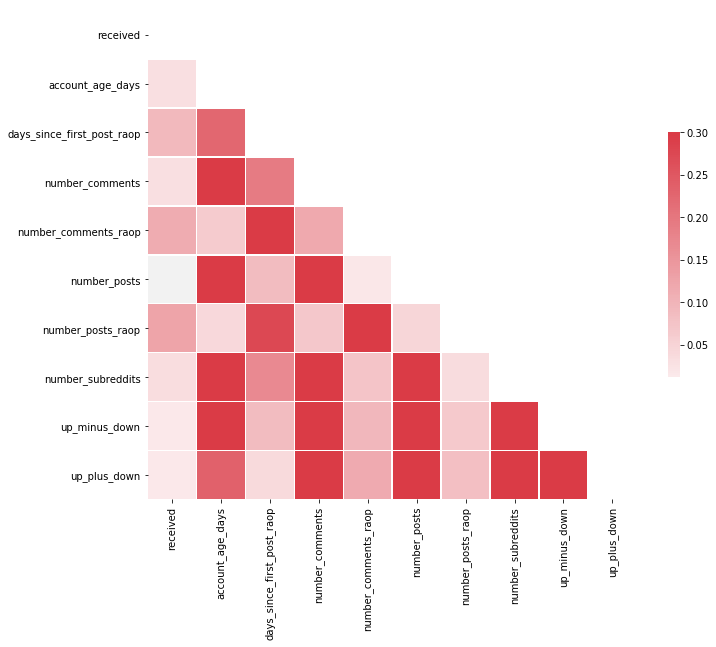

In [20]:
# Compute the correlation matrix
corr_raw = train_df_profile_clean.corr()

def my_corr_plot(my_corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(my_corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = (11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap = True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(my_corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": .5})
    
my_corr_plot(my_corr = corr_raw)

NOTES:
- Generally - this pairplot can be cut down/split up but wanted to put everything out here for first draft
- Lurkers: 
    - Tons of 0 values on participation metrics
    - Big leading spike in comments relative to posts/up/downvotes
    - Very few posts in RAOP (as would be expected) but also comments in RAOP not parituclarly correlated with any sort of participation metrics outside of RAOP 
- Only noticeable correlation with received is RAOP participation

#### Text Variables (AW + SB)

In [21]:
# Text Variables Code

## Baseline Model

Zero R rule = apply highest class % to all  
(No pizza received)

## Feature Engineering

#### Time Variables (JV)

In [22]:
# Time Variables Code

#### Requester Profile Variables (TS)

C:\Users\manat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


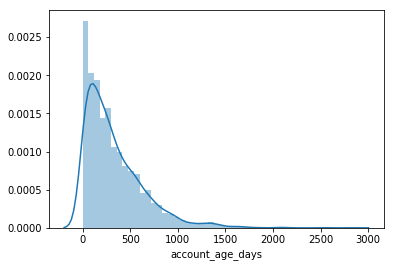

In [23]:
# Age of account - whether it appears to be a new/throwaway account or a longtime veteran
sns.distplot(train_df_profile_clean[train_df_profile_clean['account_age_days']!=0]['account_age_days']);

C:\Users\manat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


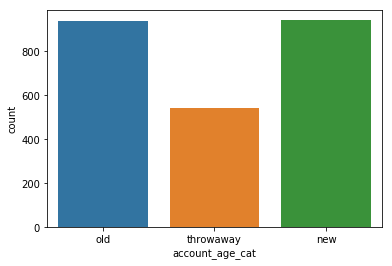

In [24]:
# Create new variable for: first (days = 0), new (days <= median for nonzero), old (days > median for nonzero)
median_account_age_nonzero = train_df_profile_clean[train_df_profile_clean['account_age_days']!=0]['account_age_days'].median()
account_conditions = [
    (train_df_profile_clean.loc[:,'account_age_days']==0),
    (train_df_profile_clean.loc[:,'account_age_days']<=median_account_age_nonzero),
    (train_df_profile_clean.loc[:,'account_age_days']>median_account_age_nonzero)]
account_choices = ['throwaway', 'new', 'old']
train_df_profile_clean['account_age_cat'] = np.select(account_conditions, account_choices, default='na')
sns.countplot(x = 'account_age_cat', data = train_df_profile_clean)

C:\Users\manat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


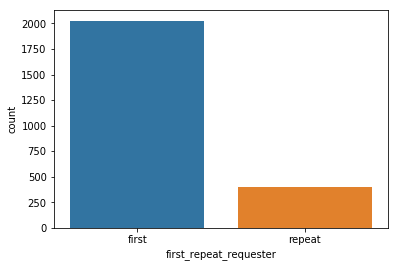

In [25]:
# Number and frequency of requests - if the requester has made requests before
train_df_profile_clean['first_repeat_requester'] = np.where(train_df_profile_clean['days_since_first_post_raop']==0, 'first', 'repeat')
sns.countplot(x='first_repeat_requester', data = train_df_profile_clean)

C:\Users\manat\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


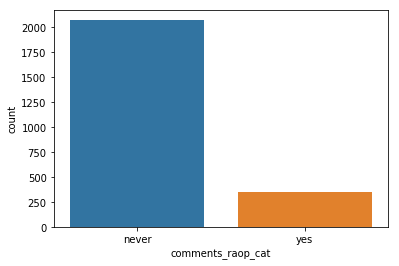

In [27]:
# Create new variable for: never (comments = 0), below (comments <= median for nonzero), above (comments > median for nonzero)
# median_comments_raop_nonzero = train_df_profile_clean[train_df_profile_clean['number_comments_raop']!=0]['number_comments_raop'].median()
# comments_raop_conditions = [
#     (train_df_profile_clean.loc[:,'number_comments_raop'] == 0),
#     (train_df_profile_clean.loc[:,'number_comments_raop'] <= median_comments_raop_nonzero),
#     (train_df_profile_clean.loc[:,'number_comments_raop'] > median_comments_raop_nonzero)]
# comments_raop_choices = ['never', 'below', 'above']
# train_df_profile_clean['comments_raop_cat'] = np.select(comments_raop_conditions, comments_raop_choices, default='na')

train_df_profile_clean['comments_raop_cat'] = np.where(train_df_profile_clean['number_comments_raop']==0, 'never', 'yes')
sns.countplot(x = 'comments_raop_cat', data = train_df_profile_clean)

In [28]:
# NOTE: this should mimic what we did above with days since last request
    # THOUGH they may capture the same thing - I will check, but for now assume days since last request is a fine replacement
    # Let me reconsider my use of days - maybe have they asked in a long while?
# Create new variable for: never (posts = 0), below (posts <= median for nonzero), above (posts > median for nonzero)
# median_posts_raop_nonzero = train_df_profile_clean[train_df_profile_clean['number_posts_raop']!=0]['number_posts_raop'].median()
# posts_raop_conditions = [
#     (train_df_profile_clean.loc[:,'number_posts_raop'] == 0),
#     (train_df_profile_clean.loc[:,'number_posts_raop'] <= median_posts_raop_nonzero),
#     (train_df_profile_clean.loc[:,'number_posts_raop'] > median_posts_raop_nonzero)]
# posts_raop_choices = ['never', 'below', 'above']
# train_df_profile_clean['posts_raop_cat'] = np.select(posts_raop_conditions, posts_raop_choices, default='na')
# sns.countplot(x = 'posts_raop_cat', data = train_df_profile_clean)

C:\Users\manat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


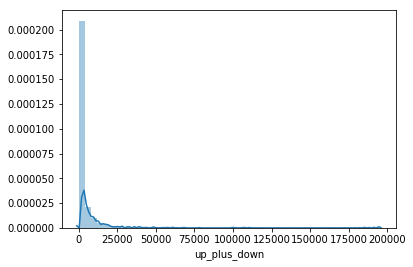

In [29]:
sns.distplot(train_df_profile_clean.loc[:,'up_plus_down']);

C:\Users\manat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


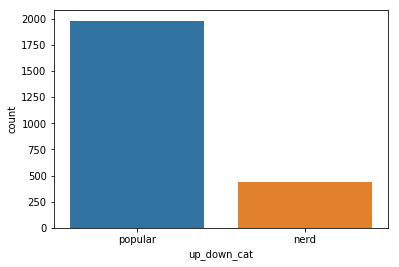

In [30]:
# Still a huge 0 spike for up/down
train_df_profile_clean['up_down_cat'] = np.where(train_df_profile_clean['up_plus_down']==0, 'nerd', 'popular')
sns.countplot(x = 'up_down_cat', data = train_df_profile_clean)

In [118]:
train_df_profile_clean.head()

,received,account_age_days,days_since_first_post_raop,number_comments,number_comments_raop,number_posts,number_posts_raop,number_subreddits,subreddits_list,up_minus_down,up_plus_down,new_old_account,account_age_cat,first_repeat_requester,comments_raop_cat,posts_raop_cat
1640,0,266.021667,0.000000,0,0,36,0,13,"[AskReddit, DotA2, Music, Rift, WTF, fffffffuu...",185,823,old,old,first,never,never
1908,0,0.000000,0.000000,0,0,0,0,0,[],0,0,new,throwaway,first,never,never
1240,0,522.582060,165.546227,567,4,52,0,63,"[AdviceAnimals, AmISexy, AskReddit, Baking, Bo...",2479,7601,old,old,repeat,above,never
584,0,0.000000,0.000000,0,0,0,0,0,[],0,0,new,throwaway,first,never,never
3011,1,52.056678,0.000000,4,0,2,0,3,"[funny, gaming, videos]",2,42,old,new,first,never,never


In [124]:
# TS NEXT STEPS
# Collapse buckets with really small numbers - median will shift for test data
# BINARIZE
# Compute the correlation matrix
# Up/Down - Hierarchy w/papers

#### Text Analysis Plan (AW + SB)
* Sentiment analysis
* Check whether the post matches with the Sub-Reddits the original poster subscribed
* Number of capitalized words

Methods:  
**TO DO** - add content on each of these methods
- **Bag-of-words** = base methodology  
- Topic modelling = potential  
- Stemming/Pre-Processing = potential (see dimensionality reduction)  

##### Count the number of words capitalized

In [29]:
## Extract the target variable and two text fields
i = 1

Y_train_np = train_df['requester_received_pizza'].values
print(Y_train_np[i])

request_text_edit_aware_train_np = train_df['request_text_edit_aware'].values
print(request_text_edit_aware_train_np[i])

request_title_train_np = train_df['request_title'].values
print(request_title_train_np[i])

requester_subreddits_at_request_train_np = train_df['requester_subreddits_at_request'].values
print(requester_subreddits_at_request_train_np[i])

False
I know, I know, I only just registered so I must be lying. Hopefully someone can not prejudge me and possibly believe me. 

Anyway... I heard about this site from one of my online friends, who is in a similar financial situation as me. I was supposed to be paid on Monday, however due to some issues with my bank I haven't been paid and am not really sure when I will be paid. This leaves me with a current balance of £2.36 on my debit card (I can provide proof). I ate the last of my food tonight, so I was hoping to get a pizza from here tomorrow. If any more information is needed then feel free and I will post on here or over PM.

Thanks in advance everyone.
[REQUEST] Pizza for tomorrow - UK
[]


In [30]:
stateAbbrList = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
otherExlcusionList = ['US', 'PS', 'EDIT', 'PM']
capCountList = []
capCategoryList = []
for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i]
    ## Replace special characters with space
    msg = re.sub('[^1-9a-zA-Z\s]+', '', msg)
    capCount = 0
    for word in msg.split():
        ## Remove if a word has only 1 character (i.e., 'I')
        if len(word) > 1:
            if word.isupper() and word not in stateAbbrList and word not in otherExlcusionList:
                print(word)
                capCount += 1
        
    capCountList.append(capCount)
#print(capCountList)

EMT
UI
RAOP
EMT
IT
IF
SOMETHING
PT
RAOP
RAOP
NEED
I9
DMV
IM
NEED
TV
REALLY
IT
RAOP
REALLY
NB
SO
AC
PIC
IT
6AM6PM
TOTAL
6PM
IT
OP
ST
5PM
CST
4PM
SCI
UK
AND
BREADSTICKS
COMPLETELY
HONEST
CRAVING
PIZZA
IV
NO
UC
BA
GF
TF2
TMHS
RAOP
EGIFT
GI
RAOP
19F
TLDR
AM
NOT
AFB
XL
RAOP
HERE
IS
THE
STORY
REAL
BU
DM
RAOP
WAY
UK
SO
RAOP
YY
SCTV
CCSI
CFIA
CFIA
MRI
MRI
MRI
FOR
LIFE
EMG
WSIB
MAAAAD
TV
BC
AGAIN
AGAIN
GPA
ROAP
EAT
ALL
THE
PIZZA
SOMEONE
PLEASE
GET
THE
PREGNANT
LADY
PIZZA
MP3
2L
SO
UNT
WOW
OPB
USA
EXHAUSTED
USA
SUFFERING
ABC
RAOP
RAOP
THANKS
TCF
RAOP
BC
DFAS
AFTER
ALL
ASAP
DO
EST
AND
NRL
PISSING
THR
LOVES
PIZZA
APT
COMPLEX
THANKS
FROM
RAOP
LOVE
ICU
UPDATE
NEED
GF
IT
RAOP
UK
PS3
RAOP
URL
RAOP
HR
BC
USA
TLDR
PLEASE
AA
DC
NICU
NICU
SPEEDING
TICKET
ALL
SO
HEAVINGLY
AND
AND
AND
SC2
EST
FINALLY
RAOP
USA
HR
GSL
EDT
UH
SO
REFUSES
HILARIOUS
UK
VERY
DC
TV
ROAP
AC
BA
UK
RP
IDS
22M
23F
NO
AVAIL
SSI
DES
ACC
IS
NYC
CST
PBJ
ANY
HEB
MAYBE
IF
USE
THESE
NAIL
CLIPPERS
CAN
CARVE
HOLE
THIS
CONTROLLER
TO
LIVE
THIS
SO

            0
0    0.231884
1    0.287324
2    0.298701
3    0.363636
4    0.583333
5    0.000000
6    0.333333
7    1.000000
8    0.000000
11   0.000000
12   1.000000
17   0.000000
23   0.500000
28   0.000000
35   0.000000
37   0.000000
118  0.000000


Text(0.5,0,'# of Capitalized Words')

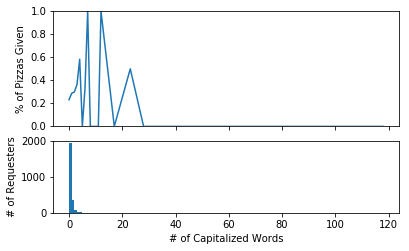

In [31]:
## Avaerge target in training by the number of capitalized words
Y_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).mean()
## Total number of observations by the number of capitalized words
n_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).count()
print(Y_byCapCount)

fig = plt.figure()
## Specify the dimensions [left, bottom, width, height]
ax1 = fig.add_axes([0.1, 0.4, 0.8, 0.4],
                   xticklabels=[], ylim=(0, 1))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.25],
                   ylim=(0, 2000))

ax1.plot(np.unique(capCountList), Y_byCapCount)
ax1.set_ylabel('% of Pizzas Given')
ax2.hist(capCountList, 120)
ax2.set_ylabel('# of Requesters')
ax2.set_xlabel('# of Capitalized Words')

In [32]:
## Bin into 2 categories: Capitalization (Yes, No)
capCategoryList = np.where(np.asarray(capCountList)>=1, 1, 0)

## Avaerge target in training by the number of capCategory
Y_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).mean()
## Total number of observations by the number of capCategory
n_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).count()
print(Y_byCapCategory)
print(n_byCapCategory)

          0
0  0.231884
1  0.300813
      0
0  1932
1   492


##### Sentiment Analysis

In [33]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.downloader.download('vader_lexicon')

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\Angela\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
## Reference: https://www.nltk.org/api/nltk.sentiment.html (CITATION NEEDED)
## Reference: http://www.nltk.org/howto/sentiment.html
sid = SentimentIntensityAnalyzer()
neuList = []
posList = []
negList = []
compoundSenList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i] 
    ss = sid.polarity_scores(msg)
    neuList.append(ss['neu'])
    posList.append(ss['pos'])
    negList.append(ss['neg'])
    compoundSenList.append(ss['compound'])

Text(0.5,1,'Histogram of Compound Score')

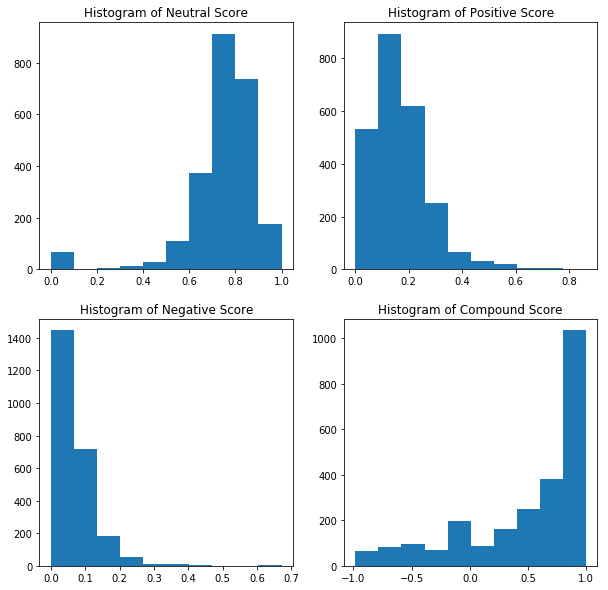

In [35]:
np.histogram(np.asarray(neuList), bins=[0, 0.25, 0.5, 0.75, 1])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#n, bins, patches = ax[1,1].hist(np.asarray(neuList), 10, density=1)
ax[0,0].hist(np.asarray(neuList))
ax[0,0].set_title('Histogram of Neutral Score')
ax[0,1].hist(np.asarray(posList))
ax[0,1].set_title('Histogram of Positive Score')
ax[1,0].hist(np.asarray(negList))
ax[1,0].set_title('Histogram of Negative Score')
ax[1,1].hist(np.asarray(compoundSenList))
ax[1,1].set_title('Histogram of Compound Score')

In [36]:
## Reference: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [37]:
sentimentX = np.c_[np.asarray(neuList), np.asarray(posList), np.asarray(negList), np.asarray(compoundSenList)]
#from sklearn.linear_model import LogisticRegression
lgModel = LogisticReg()
lgModel.fit(sentimentX, Y_train_np)
print(lgModel.coef_)
print(lgModel.p_values)

## Note only neutral score and compound score are significant.

[[ 0.2591324  -0.69782843 -0.22717212  0.30297536]]
[0.04694922135723504, 0.18158666264240186, 0.7924110962287936, 0.02736518836208671]


C:\Users\Angela\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Models

DEV DATA Only  

Models we plan to test:
- Logistic Regression
    * **TO DO** add one sentence on algorithm methodology and potential applicability
- Naive Bayes  
- Decision Trees / Random Forest

Based on preliminary results, we will focus on the most promising model and begin to refine and tune that method.  

There are two sets of hyperparameters which we will be able to adjust in pursuit of a more accurate model:  
- **Model Parameters** _(will be dependent on which is our final model)_
    - Logistic Regression
        * `solver` - Will seek to find the optimal solver given the data size and feature dentiy (newton-cg, lbfgs, liblinear, sag, or saga)
        * `penalty` - Select norm for penalization (l1 or l2)
        * `C` - Adjust to reduce overfitting
        * `tol` & `max_iter` - Deal with convergence issues
    - Naive Bayes (BernoulliNB)
        * `alpha` - Adjust smoothing for issues with sparse data
    - Decision Trees / Random Forest
        * `max_depth` & `n_estimators` - Achieve parsimonious level of detail in the forest
        * `criterion` - Adjust method for determining the quality of each split (gini or entropy)
- **Feature Engineering Parameters**
    - Dimensionality reduction
        * `analyzer` - Find optimal unit of observation for feature creation
        * `vocabulary` - Create a more limited vocabulary using logistic regression with l1 penalty to identify and remove features with low or 0 weight
        * `min_df` - Limit reliance on rare words without losing predictive power  
        * `stop_words` - Remove overly-common words
    - Error Review
        * `pre-processor` - Create custom pre-processing algorithm to remove/edit idiosynchratic at-issue words/phrases found in review of false negatives/positives

## Results

Once an optimal model has been build with training data and tested with dev data, we will run the test data through the model and output a predicted class (boolean, pizza received or not).  
This test result will be _submitted via csv to Kaggle_, which will return an accuracy score.  
This accuracy score will be compared against the benchmark ZeroR score to evaluate the predictive power of the model.